In [1]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import scipy.integrate as integrate

import ipywidgets as widgets
from IPython.display import display
import pickle


import torch

import matplotlib.pyplot as plt

import pandas as pd
from functools import partial

import zuko
import lampe.inference
import lampe.utils
from tqdm.notebook import tqdm_notebook as tqdm
from lampe.utils import GDStep

from itertools import islice
from lampe.data import JointLoader

In [2]:
theta_true = torch.Tensor([0])
prior = torch.distributions.Normal(0, 5)
N=100
theta_grid = np.linspace(-8,8,1000)
N_simu =  50_000

In [3]:
M = 100_000
warm_up_steps =  20_000

sigma = 0.01
tau = 0.25
rho = 1/2

In [4]:

def posterior_summaries(thetas, x1, x2,sigma_2_y=1):

    """Posterior when observing x= mean(z1...zn), var(z1...zn)"""
    def improper_posterior_summaries(theta,x1=x1,x2=x2):
        likelihood_x1_part = -N*np.square(theta - x1)/(2*sigma_2_y**2)
        likelihood_x2_part = -0.5*np.square(sigma_2_y - x2)/(2*np.square(sigma_2_y)/N)
        prior_part = -np.square(theta)/50
        return np.exp(likelihood_x1_part)*np.exp(likelihood_x2_part)*np.exp(prior_part)
    z_summaries, eps = integrate.quad(improper_posterior_summaries, -25, 25)
    return [improper_posterior_summaries(theta,x1,x2)/z_summaries for theta in thetas]

In [5]:
def get_true_post(task_name, x_star,sigma_y_2=1):
    theta_grid_t =theta_grid  # Convert theta_grid to a torch tensor


    # We observe x = (x1, x2) = (mean, var)
    post = posterior_summaries(theta_grid_t, x_star[0], x_star[1],sigma_y_2) 

   # post = torch.stack(post).cuda()  # Move post to CUDA
    return post


In [6]:
device=torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [7]:
class Gaussian():
    
    def __init__(self, theta_true, N_simu, sigma_y_2) -> None:
        self.name = "Gaussian"
        self.prior = torch.distributions.Normal(0,5)
        self.theta_true = theta_true
        self.sigma_y_2 = sigma_y_2
        data = self.generate_data(N_simu, sigma_y_2)
        data_test = self.generate_data(N_simu//10, sigma_y_2)
        true_obs_data = self.generate_data(1,sigma_y_2)
        x0 = true_obs_data["x"]
        y0 = x0 + true_obs_data["eps"]
        x0_scaled = (x0 - data["scale_parameters"][0])/data["scale_parameters"][1]
        y0_scaled = (y0 - data["scale_parameters"][0])/data["scale_parameters"][1]
        
        self.data = data
        self.data_test= data_test
        self.x0 = x0.squeeze()
        self.y0 = y0.squeeze()
        self.x0_scaled = x0_scaled
        self.y0_scaled = y0_scaled
    def prior_sample(self, n):
        return self.prior.sample((n, ))
    
    def generate_data(self, N, sigma_y_2=1):
        thetas = self.prior_sample(N)
        sigma_eps = sigma_y_2-1
        res = {}
        res["theta"] = thetas
        means_and_vars = torch.zeros((N, 2), device=device)
        
        for i, theta in enumerate(thetas):
            z = torch.distributions.Normal(theta, 1).sample((100,)).to(device)
            mean = z.mean()
            var = z.var()
            means_and_vars[i] = torch.stack([mean.unsqueeze_(0), var.unsqueeze_(0)]).squeeze_()

        res["x"] = means_and_vars

        norm_max = -1
        for n_run in range(10):
            eps = torch.distributions.Normal(torch.zeros_like(res["x"]), np.sqrt(sigma_eps)).sample().to(device)
            if torch.norm(eps) > norm_max:
                epsilons = eps
                norm_max = torch.norm(eps)
        res["eps"] = epsilons
        scale_mean, scale_std = res["x"].mean(0), res["x"].std(0)
        res["scale_parameters"] = scale_mean, scale_std
        res["scaled_x"] = (res["x"] - scale_mean) / scale_std
        return res
    
    def true_post(self, x_star, sigma_2_y=None):
        if sigma_2_y is None:
            sigma_2_y = self.sigma_y_2
        theta_grid_t = np.linspace(-8,8,1000)
        post = posterior_summaries(theta_grid_t, x_star[0], x_star[1],sigma_2_y) 
        return post
        

In [8]:
sigma_2_y = 2

In [9]:
def scale(quantity):
    mean = quantity.mean(0)
    std = quantity.std(0)
    return (quantity-mean)/std, mean, std


In [10]:
def build_nsf(features, context):
    """Callable to instantiate the NPE with NSFs"""
    return zuko.flows.NSF(features, context, bins=10, transforms=5).to(device)

def train_flow(flow, loss, theta, x, theta_test, x_test):
    optimizer = torch.optim.Adam(flow.parameters(), lr=5e-3)
    theta_test = theta_test.unsqueeze(-1).to(device)
    data = lampe.data.JointDataset(theta.to(device), x.to(device))
    loader = lampe.data.DataLoader(data, 256)
    
    with torch.no_grad():
        min_loss = loss(theta_test, x_test.to(device))
    min_loss_list = [min_loss.item()]  # Convert min_loss to a scalar
    
    flow.train()

    for epoch in range(50):
        for theta_batch, x_batch in loader:
            theta_batch = theta_batch.unsqueeze(-1).to(device)
            x_batch = x_batch.to(device)
            losses = loss(theta_batch, x_batch)
            optimizer.zero_grad()
            losses.backward()
            optimizer.step()
        
        # Checking for early stopping
        with torch.no_grad():
            loss_test = loss(theta_test, x_test.to(device))
            min_loss_list.append(loss_test.item())  # Convert loss_test to a scalar
            if len(min_loss_list) - np.argmin(min_loss_list) > 5: # No improvement in loss(test) for the last 5 iterations
                # Early stop  

                break

    flow.eval()
    return flow

def create_train_flow(task, data, data_test):
    theta = data["theta"]
    theta_test = data_test["theta"]
    shape_x = lambda x: 2 if x == "Gaussian" or x == "two_z" else 1
    flow = lampe.inference.NPE(theta_dim=1, x_dim=shape_x(task.name), build=build_nsf).to(device)
    loss = lampe.inference.NPELoss(flow).to(device)
    x = data["scaled_x"].to(device)
    x_test = data_test["scaled_x"].to(device)
    flow = train_flow(flow, loss, theta, x, theta_test, x_test)
    return flow


task = Gaussian(theta_true=0,N_simu=N_simu,sigma_y_2= sigma_2_y)
data = task.data
data_test = task.data_test
q_NPE = create_train_flow(task, data, data_test) 


In [11]:
def train_unconditional_flow(flow, loss, x, x_test):
    optimizer = torch.optim.Adam(flow.parameters(), lr=1e-2)
    loader = torch.utils.data.DataLoader(x.to(device), 256)
    
    with torch.no_grad():
        min_loss = loss(x_test.to(device))
    min_loss_list = [min_loss.item()]  # Convert min_loss to a scalar
    
    flow.train()


    for epoch in range(50):
        for x_batch in loader:
            x_batch = x_batch.to(device)
            losses = loss(x_batch)
            optimizer.zero_grad()
            losses.backward()
            optimizer.step()
        
        # Checking for early stopping
        with torch.no_grad():
            loss_test = loss(x_test.to(device))
            min_loss_list.append(loss_test.item())  # Convert loss_test to a scalar
            if len(min_loss_list) - np.argmin(min_loss_list) > 5: # No improvement in loss(test) for the last 5 iterations
                # Early stop  

                break
    flow.eval()
    return flow

def create_train_unconditional_flow(task, data, data_test):
    shape_x = lambda x: 2 if x == "Gaussian" or x == "two_z" else 1
    flow = zuko.flows.NAF(features=shape_x(task.name), context=0).to(device) #!
    loss = lambda x: -flow().log_prob(x).mean()
    x = data["scaled_x"].to(device)
    x_test = data_test["scaled_x"].to(device)
    flow = train_unconditional_flow(flow, loss, x, x_test)
    return flow


q_x_NF = create_train_unconditional_flow(task, data, data_test)


In [12]:
npe_samples_x = q_NPE.flow(task.x0_scaled).sample((20_000,))

true_post = task.true_post(task.x0.squeeze().cpu().numpy())

npe_samples_y = q_NPE.flow(task.y0_scaled).sample((20_000,))

theoritical_post_y = task.true_post(task.y0.squeeze().cpu().numpy(),sigma_2_y)

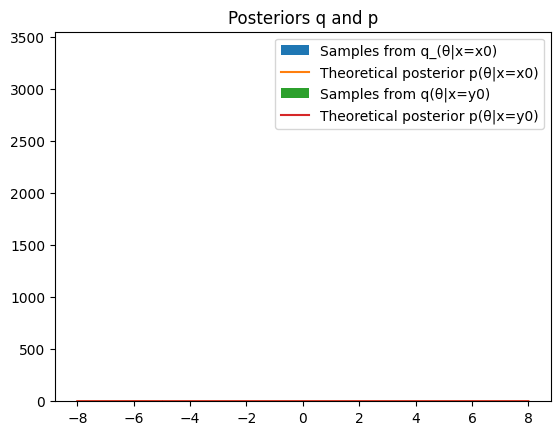

In [13]:
fig, ax = plt.subplots()
ax.hist(npe_samples_x.cpu().squeeze().cpu().numpy(), bins=400, density=True, label="Samples from q_(θ|x=x0)") #!
ax.plot(theta_grid, true_post, label="Theoretical posterior p(θ|x=x0)")
ax.hist(npe_samples_y.cpu().squeeze().numpy(), bins=400, density=True, label="Samples from q(θ|x=y0)")
ax.plot(theta_grid, theoritical_post_y, label="Theoretical posterior p(θ|x=y0)")

ax.set_title("Posteriors q and p")
#ax.set_xlim(3, 6)
ax.legend()
plt.show()

In [14]:
from itertools import islice

In [15]:

import torch.distributions as dist



# Define the proposal function
def proposal(x_curr):

    return x_curr + dist.Normal(0, 1).sample(x_curr.shape).to(device)

# Define the f function
def f(y0, x, rho, sigma, tau, q_x_NF):
    D = x.shape[-1]
    res = torch.zeros_like(x)
    for j in range(D):
        xj = x[:,j]
        yj = y0[j]
        zj = dist.Bernoulli(rho).sample().to(device)
        if not zj:
            spike_dist = dist.Normal(xj.detach(), torch.tensor(sigma).to(device))
            res[:,j] = torch.exp(spike_dist.log_prob(yj))
        else:
            slab_dist = dist.Cauchy(xj.detach(), torch.tensor(tau).to(device))
            res[:,j] = torch.exp(slab_dist.log_prob(yj))
    return res * torch.exp(q_x_NF().log_prob(x))

def mcmc(x0, warm_up_steps, M, y0, rho, sigma, tau, q_x_NF):

    x_curr = x0.to(device)
    my_samples = torch.empty((warm_up_steps + M, x0.shape[1])).to(device)
    log_f_x_curr = f(y0, x_curr, rho, sigma, tau, q_x_NF).log()
    
    for i in tqdm(range(warm_up_steps + M)):
        x_star = proposal(x_curr)
        log_f_x_star = f(y0, x_star, rho, sigma, tau, q_x_NF).log()

        log_a = log_f_x_star - log_f_x_curr

        a = torch.exp(log_a)

        u = torch.FloatTensor(a.shape).uniform_().to(device)

        mask = u < a

        x_curr = torch.where(mask, x_star, x_curr)
        log_f_x_curr = torch.where(mask, log_f_x_star, log_f_x_curr)

      #  my_samples[i] = x_curr
        my_samples[i] = x_curr


    my_samples = my_samples[warm_up_steps:]
    #my_samples = torch.stack(my_samples)
    return my_samples



In [16]:
with torch.no_grad():
    xm = mcmc(torch.zeros(1,2).to(device), warm_up_steps, M, task.y0_scaled.squeeze().to(device), rho, sigma, tau, q_x_NF)


  0%|          | 0/120000 [00:00<?, ?it/s]

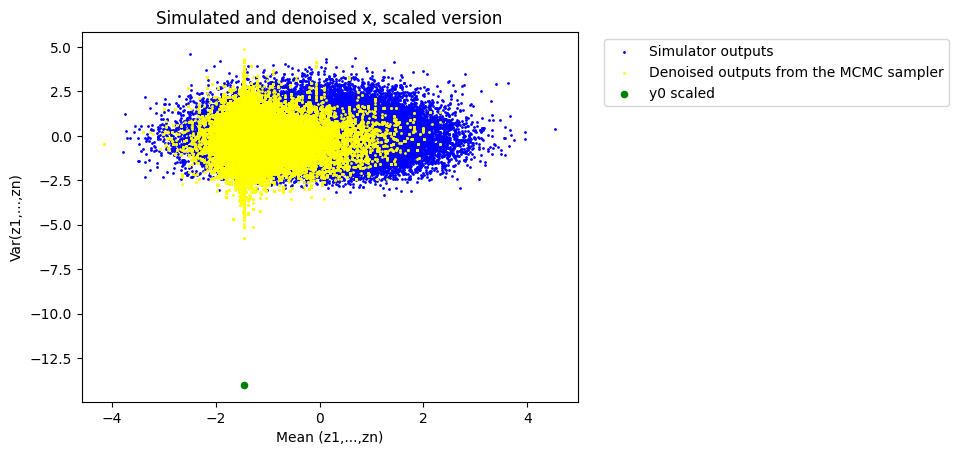

In [17]:
fig, ax = plt.subplots()

ax.scatter(x=data["scaled_x"][:,0].cpu(),y=data["scaled_x"][:,1].cpu(), color="blue", label="Simulator outputs", s=1)
ax.scatter(x=xm[:,0].cpu(),y=xm[:,1].cpu(), label="Denoised outputs from the MCMC sampler", color="yellow", s=1)
ax.scatter(x=task.y0_scaled.cpu()[:,0],y=task.y0_scaled.cpu()[:,1], label="y0 scaled", color="green", s=20)
ax.set_xlabel("Mean (z1,...,zn)")
ax.set_ylabel("Var(z1,...,zn)")
ax.set_title("Simulated and denoised x, scaled version")
ax.legend(bbox_to_anchor=(1.04, 1), loc="upper left")

In [18]:
rnpe_samples = q_NPE.flow(xm).sample()

In [19]:
true_post_y = posterior_summaries(theta_grid, task.y0.cpu().squeeze()[0].item(),task.y0.cpu().squeeze()[1].item(),sigma_2_y)

In [20]:
npe_samples = q_NPE.flow(task.y0_scaled).sample((20_000,))
true_post = task.true_post(task.y0.squeeze().cpu().numpy(),sigma_2_y)


(-2.0, 2.0)

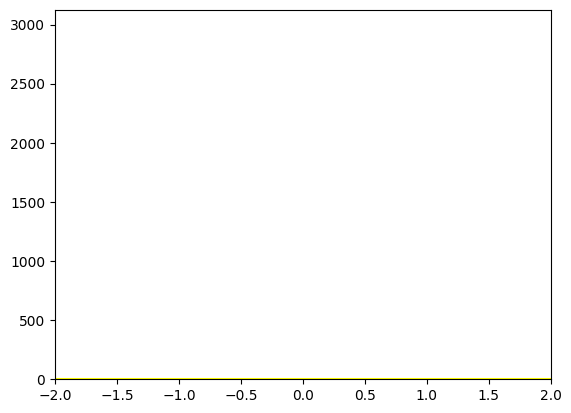

In [21]:
plt.hist(npe_samples.squeeze().cpu(),bins=200, density=True,color="green",alpha=0.5,label="NPE samples q(θ|y0)")
plt.hist(rnpe_samples.squeeze().cpu(),bins=200, density=True, color="red",alpha=0.5, label="RNPE samples q(θ|y0)")
plt.plot(theta_grid,true_post_y,color='yellow', label=" p(θ|y0) under the true DGP")
plt.xlim(-2,2)

In [22]:
sigma_2_y

2

In [23]:
def compute_distances(true_post_density,sample):
    true_post_samples = np.random.choice(theta_grid,size=100_000,p=true_post_density/sum(true_post_density))
    mean_true, std_true = np.mean(true_post_samples), np.std(true_post_samples)
    mean_sample, std_sample = np.mean(sample), np.std(sample)
    return np.square(mean_true-mean_sample) +np.square(np.log(std_true/std_sample))

In [24]:
compute_distances(true_post_y, rnpe_samples.cpu().numpy())

11.215393563252244

In [25]:
def compute_rnpe_npe(task_name, sigma_2):
    
    n_runs = 5
    
    norm_npe_rnpe = []
    npe_samples_x_l=  []
    npe_samples_y_l= []
    theoritical_post_y_l = []
    rnpe_samples_l = []
    
    for _ in tqdm(range(n_runs), leave=False):
        task = Gaussian(theta_true=0, N_simu=N_simu, sigma_y_2= sigma_2) #TODO Changer selon task_name
        data = task.data
        data_test = task.data_test
        q_NPE = create_train_flow(task, data, data_test)
        q_x_NF = create_train_unconditional_flow(task, data, data_test)
        with torch.no_grad():
            print()
            xm = mcmc(torch.zeros(1,2).to(device), warm_up_steps, M, task.y0_scaled.squeeze().to(device), rho, sigma, tau, q_x_NF)
        
        npe_samples_x = q_NPE.flow(task.x0_scaled).sample((M, ))
        npe_samples_y = q_NPE.flow(task.y0_scaled).sample((M,))
        theoritical_post_y = task.true_post(task.y0.squeeze().cpu().numpy(), sigma_2)
        rnpe_samples = q_NPE.flow(xm).sample()
        norm_npe_rnpe.append(npe_samples_y.mean() - rnpe_samples.mean())
        
        npe_samples_x_l.append(npe_samples_x)
        npe_samples_y_l.append(npe_samples_x)
        theoritical_post_y_l.append(theoritical_post_y)
        rnpe_samples_l.append(rnpe_samples)
    imax = np.argmax(norm_npe_rnpe)
    npe_samples_x = npe_samples_x_l[imax]
    npe_samples_y = npe_samples_y_l[imax]
    theoritical_post_y = theoritical_post_y_l[imax]
    rnpe_samples = rnpe_samples_l[imax]
    return npe_samples_x, npe_samples_y, theoritical_post_y_l, rnpe_samples
            
npe_samples_x, npe_samples_y, theoritical_post_y_l, rnpe_samples = compute_rnpe_npe("Gaussian", 2)         

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/120000 [00:00<?, ?it/s]

  0%|          | 0/120000 [00:00<?, ?it/s]

  0%|          | 0/120000 [00:00<?, ?it/s]

  0%|          | 0/120000 [00:00<?, ?it/s]

  0%|          | 0/120000 [00:00<?, ?it/s]

In [26]:
results = {}
sigmas_2 = np.arange(1,4,0.5)
with tqdm(sigmas_2, unit ='Sigma²', desc='Corruption') as tq:
    for sigma_2 in tq:
        print(sigma_2)
        results[sigma_2] = {}
        results[sigma_2]["npe_samples_x"],results[sigma_2]["npe_samples_y"],results[sigma_2]["theoritical_post_y_l"],results[sigma_2]["rnpe_samples"] =  compute_rnpe_npe(Gaussian, sigma_2)

Corruption:   0%|          | 0/6 [00:00<?, ?Sigma²/s]

1.0


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/120000 [00:00<?, ?it/s]

  0%|          | 0/120000 [00:00<?, ?it/s]

  0%|          | 0/120000 [00:00<?, ?it/s]

  0%|          | 0/120000 [00:00<?, ?it/s]

  0%|          | 0/120000 [00:00<?, ?it/s]

1.5


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/120000 [00:00<?, ?it/s]

  0%|          | 0/120000 [00:00<?, ?it/s]

  0%|          | 0/120000 [00:00<?, ?it/s]

  0%|          | 0/120000 [00:00<?, ?it/s]

  0%|          | 0/120000 [00:00<?, ?it/s]

2.0


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/120000 [00:00<?, ?it/s]

  0%|          | 0/120000 [00:00<?, ?it/s]

  0%|          | 0/120000 [00:00<?, ?it/s]

  0%|          | 0/120000 [00:00<?, ?it/s]

  0%|          | 0/120000 [00:00<?, ?it/s]

2.5


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/120000 [00:00<?, ?it/s]

  0%|          | 0/120000 [00:00<?, ?it/s]

  0%|          | 0/120000 [00:00<?, ?it/s]

  0%|          | 0/120000 [00:00<?, ?it/s]

(array([0.30363359, 0.05320589, 0.03080341, 0.01840168, 0.01200133,
        0.01240137, 0.00680075, 0.00760084, 0.00640071, 0.00600066,
        0.00680062, 0.00600066, 0.00560062, 0.00600066, 0.00560062,
        0.00520058, 0.0072008 , 0.00680062, 0.00600066, 0.01000111,
        0.01040115, 0.00600066, 0.00800089, 0.00960106, 0.00680062,
        0.01000111, 0.00960106, 0.01240137, 0.01000111, 0.01000111,
        0.01240137, 0.00960088, 0.01040115, 0.00840093, 0.01160128,
        0.00960106, 0.01240137, 0.01080099, 0.01120124, 0.01000111,
        0.01280142, 0.01120124, 0.0136015 , 0.01600162, 0.01400155,
        0.01440159, 0.01320133, 0.01200133, 0.01280142, 0.01320146,
        0.01520154, 0.01320146, 0.01480164, 0.00880089, 0.01280142,
        0.01240137, 0.01120113, 0.01400155, 0.01440159, 0.00920102,
        0.0148015 , 0.01520168, 0.01880208, 0.01080109, 0.02240248,
        0.0172019 , 0.01560173, 0.01800182, 0.0172019 , 0.02160239,
        0.01960198, 0.0208023 , 0.0172019 , 0.02

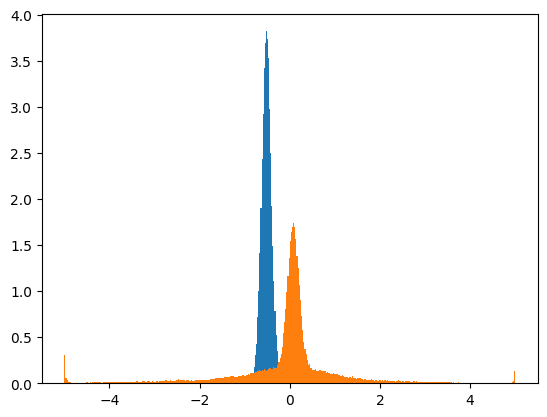

In [ ]:
plt.hist(npe_samples_y.squeeze().cpu().numpy(), bins=400, density=True)
plt.hist(rnpe_samples.cpu().numpy(), bins=400, density=True)